# 4. Dimensionality reduction

## Introduction

**Purpose:** Previous work in `3-join-and-visualize.ipynb` identified some interesting correlations between a census tract's green space (as its vegetation index from remote sensing) and various socioeconomic features. However, there are quite a few correlating socioeconomic features, making it difficult to prepare a clean and digestable visualization.

However, several of these features are likely intimately related, such as the age breakdown of the tract's residents and how long they have lived in their homes. Dimensionality reduction may be able to provide some features to use in a more readily interpretable plot.

**Contents:** The notebook shows:
* Light cleaning of the data to prepare for PCA, such as dropping null values and duplicative features.
* Determination and exploration of principal components.

**Conclusions:** Key conclusions & outputs are:
* At the census tract level, about 2/3 of the variance in green space (as NDVI) may be reduced to the first 3 principal components:
    * PC-1 roughly corresponds to older, long-term residency in suburbs
    * PC-2 roughly corresponds to middle-aged whiteness in LA county
    * PC-3 is similar to PC-2, but removes the race feature

## Import required libraries

In [1]:
# For manipulating tabular data
import pandas as pd
import numpy as np

In [2]:
# For dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
# For plotting
import seaborn as sns

## Load the data
Relevant features were computed, prioritized, and combined in `3-join-and-visualize.ipynb`. Now it is simply a matter of loading the simplified data set:

In [4]:
greenspace = pd.read_csv("greenspace_highlights.csv", index_col = "Tract_FIPS")
greenspace.head()

,Age_20-34_percent,Age_35-54_percent,Age_55+_percent,NDVI_2021-05-17,County,Race_white_percent,Pop_density_per_km2,Residency_before_2000_percent
Tract_FIPS,,,,,,,,
6037262601,11.040828,24.583094,26.135710,0.469434,Los Angeles,76.365727,960.680332,35.876742
6037300100,10.766046,28.666985,21.054308,0.418855,Los Angeles,66.746297,1367.574012,48.178506
6037300501,14.511352,31.359000,19.315564,0.265917,Los Angeles,55.347154,2411.416737,33.734940
6037310701,23.856671,21.499293,29.467232,0.156655,Los Angeles,80.433758,4115.737408,12.346760
6037300200,13.834139,25.734474,25.529937,0.339691,Los Angeles,54.072146,2766.480829,40.222335


In [5]:
green_y = greenspace["NDVI_2021-05-17"]
green_x = greenspace.drop(columns = ["NDVI_2021-05-17"])

## Clean up the data

### One-hot encode the county data
The county categorical data should either be one-hot encoded or dropped. Here, we will one-hot encode it as a new boolean feature, `County_is_LA`.

In [6]:
green_x["County_is_LA"] = greenspace["County"] == "Los Angeles"
green_x = green_x.drop(columns = ["County"])
green_x.head()

,Age_20-34_percent,Age_35-54_percent,Age_55+_percent,Race_white_percent,Pop_density_per_km2,Residency_before_2000_percent,County_is_LA
Tract_FIPS,,,,,,,
6037262601,11.040828,24.583094,26.135710,76.365727,960.680332,35.876742,True
6037300100,10.766046,28.666985,21.054308,66.746297,1367.574012,48.178506,True
6037300501,14.511352,31.359000,19.315564,55.347154,2411.416737,33.734940,True
6037310701,23.856671,21.499293,29.467232,80.433758,4115.737408,12.346760,True
6037300200,13.834139,25.734474,25.529937,54.072146,2766.480829,40.222335,True


## Are the age features duplicative?

It seems plausible that the age features might be duplicative. As in, where there are fewer 20-34 year olds, there may be more 55+ year olds. If so, we do not need both features. To determine if that's the case, we'll scale each column to and then calculate a covariance matrix.

In [7]:
agecols = ["Age_20-34_percent", "Age_35-54_percent", "Age_55+_percent"]

In [8]:
greenscaled = (green_x[agecols] - green_x[agecols].mean()) / green_x[agecols].std()

In [9]:
greenscaled.head()

,Age_20-34_percent,Age_35-54_percent,Age_55+_percent
Tract_FIPS,,,
6037262601,-1.376404,-0.468335,1.092890
6037300100,-1.408452,0.332609,0.374451
6037300501,-0.971644,0.860575,0.128617
6037310701,0.118281,-1.073140,1.563920
6037300200,-1.050626,-0.242523,1.007242


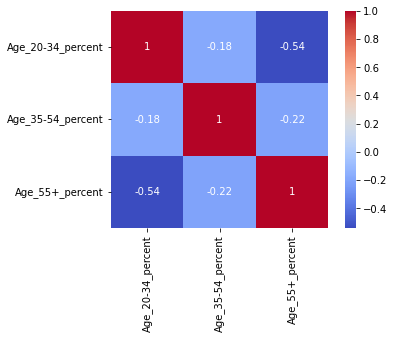

In [10]:
sns.heatmap(greenscaled.cov(),
            square = True,
            cmap = "coolwarm",
            annot = True)
sns.set(rc = {'figure.figsize':(8, 8)})

The `Age_20-34_percent` and `Age_55+_percent` columns are reasonably redundant. One can be dropped.

In [11]:
green_x = green_x.drop(columns = ["Age_20-34_percent"])

### Check for null values

In [12]:
pd.isna(green_x).sum() / len(green_x) * 100

Age_35-54_percent                0.674807
Age_55+_percent                  0.674807
Race_white_percent               0.674807
Pop_density_per_km2              0.128535
Residency_before_2000_percent    0.931877
County_is_LA                     0.000000
dtype: float64

Under 1% of the data is null values. These can safely be dropped.

In [13]:
green_x = green_x.dropna(how = "any")

## Principal component analysis

We'll make a pipeline to bundle the scaling & PCA together.

In [14]:
pca_pipe = Pipeline(steps = [("z-scaler", StandardScaler()),
                             ("PCA", PCA())])

In [15]:
pca = pca_pipe.fit_transform(green_x)
greenpca = pd.DataFrame(pca, columns = ["PC-" + str(i) for i in range(1, pca.shape[1] + 1)])
greenpca.index = green_x.index
greenpca.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
Tract_FIPS,,,,,,
6037262601,1.897549,-0.358968,0.297550,-1.060841,-0.131577,-0.202906
6037300100,1.619898,-0.368008,1.383330,-0.255405,0.116227,-0.925250
6037300501,0.522816,0.097970,1.297473,-0.111065,-0.007302,-0.082559
6037310701,1.052362,-0.071310,-1.188436,-1.978338,-0.079070,0.881449
6037300200,1.362860,-0.951752,0.608784,-0.249540,0.273554,-0.113437


## How significant is each principal component?

To determine how meaningfully each principal component contributes to the overall variance, let's make a plot.

First, grab the variance ratios:

In [16]:
var_ratios = pd.DataFrame(pca_pipe.steps[1][1].explained_variance_ratio_,
                          index = greenpca.columns,
                          columns = ["Fraction_variance"]
                         )

In [17]:
var_ratios["Cumulative_variance"] = np.cumsum(var_ratios["Fraction_variance"].values)

In [18]:
var_ratios

,Fraction_variance,Cumulative_variance
PC-1,0.333337,0.333337
PC-2,0.193805,0.527141
PC-3,0.165911,0.693053
PC-4,0.127618,0.820671
PC-5,0.095906,0.916577
PC-6,0.083423,1.000000


<AxesSubplot:xlabel='Principal Component', ylabel='Cumulative Variance Fraction'>

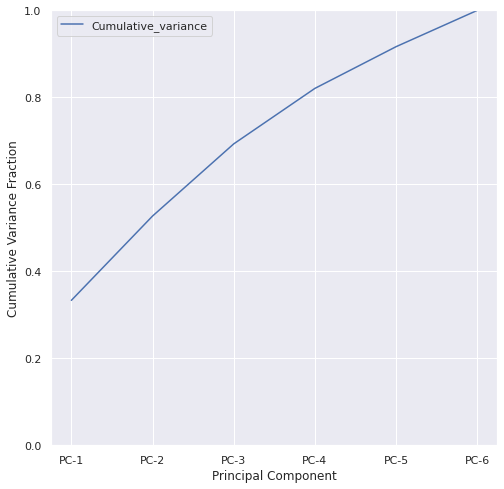

In [19]:
var_ratios.plot(kind = "line",
                y = "Cumulative_variance",
                ylim = (0, 1),
                xlabel = "Principal Component",
                ylabel = "Cumulative Variance Fraction")

The first 3 principal components account for just over 2/3 of all the variance.

## What features contribute to each principal component?

In [20]:
components = pd.DataFrame(pca_pipe.steps[1][1].components_ ** 2,
                          columns = green_x.columns,
                          index = greenpca.columns)
components.sum()

Age_35-54_percent                1.0
Age_55+_percent                  1.0
Race_white_percent               1.0
Pop_density_per_km2              1.0
Residency_before_2000_percent    1.0
County_is_LA                     1.0
dtype: float64

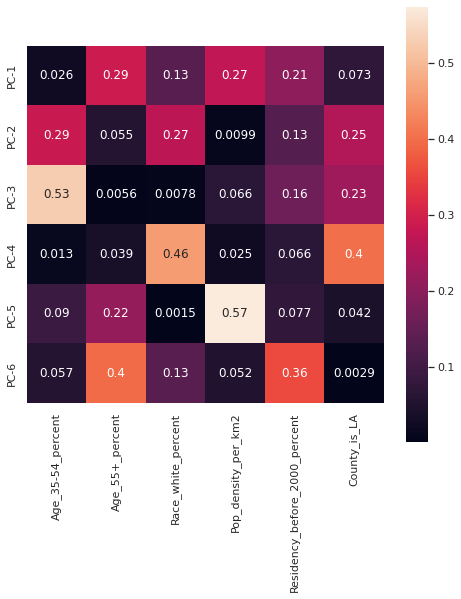

In [21]:
hmap = sns.heatmap(components,
                   annot = True,
                   square = True)
sns.set(rc = {'figure.figsize':(8, 8)})

Very roughly, PC-1 represents older, long-term residency in suburbs. PC-2 roughly represents middle-aged whiteness in LA county.

## Plot vegetation index with principal components

In [22]:
greenpca["NDVI_20210517"] = green_y

<AxesSubplot:title={'center':'Principal Components of Tract-Level Green Space in Southern California'}, xlabel='PC-1: older, long-term residency in suburbs', ylabel='PC-2: middle-aged whiteness in LA county'>

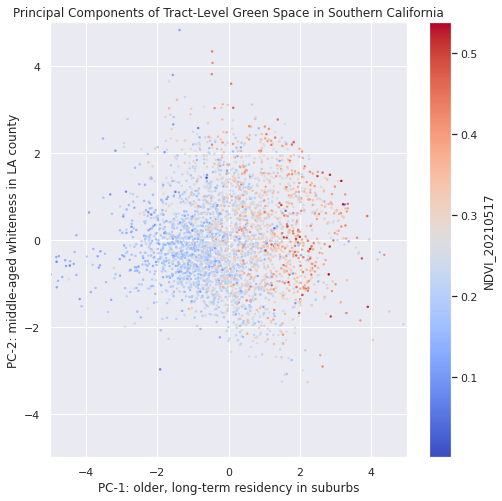

In [23]:
greenpca.plot(kind = "scatter",
              x = "PC-1",
              y = "PC-2",
              c = "NDVI_20210517",
              sharex = False, # The x-axis vanishes if this is not specified
              xlim = (-5, 5),
              ylim = (-5, 5),
              cmap = "coolwarm",
              s = 2,
              xlabel = "PC-1: older, long-term residency in suburbs",
              ylabel = "PC-2: middle-aged whiteness in LA county",
              title = "Principal Components of Tract-Level Green Space in Southern California")

It looks as if PC-2 is actually not contributing much to the delineation of vegetation index here. There is a fairly clear-cut break for NDVI = 0.25 at PC-1 = 0. Out of curiousity, let's see what it looks like if we only plot PC-1 vs. NDVI:

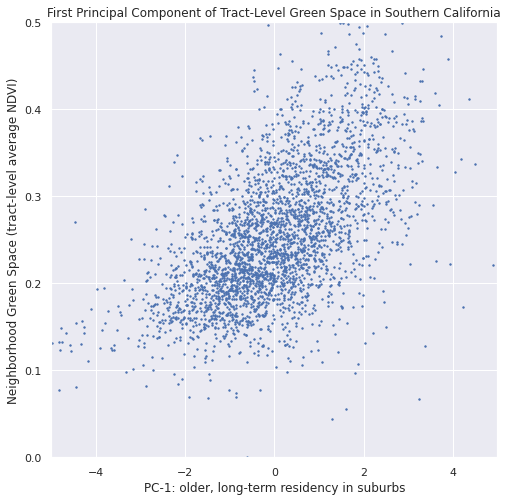

In [24]:
pcaplot2 = greenpca.plot(kind = "scatter",
                         x = "PC-1",
                         y = "NDVI_20210517",
                         sharex = False, # The x-axis vanishes if this is not specified
                         xlim = (-5, 5),
                         ylim = (0, 0.5),
                         s = 2,
                         xlabel = "PC-1: older, long-term residency in suburbs",
                         ylabel = "Neighborhood Green Space (tract-level average NDVI)",
                         title = "First Principal Component of Tract-Level Green Space in Southern California")

In [25]:
pcaplot2.get_figure().savefig("images/pca.png")

If this were a classification problem (such as "is NDVI greater than 0.25 or not?"), the first 1-2 principal components do a decent job of providing predictive value.